# Data Cleaning

## Outline
0. Load and join dataframes
1. Handle missing values
   - Identify columns with missing data
   - Decide on appropriate strategies for each column
   - Impute or handle missing values as needed
2. Convert data types
   - Change 'start_date' to datetime format
   - Convert 'home_line_scores' and 'away_line_scores' to usable format
3. Handle outliers
   - Check for and address unrealistic values in numerical columns
4. Create derived features
   - Calculate point difference
   - Generate 'winner' column
   - Create time-based features from 'start_date'
5. Review and validate cleaned dataset

## Load Data

In [1]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Load the games data from the parquet file
games_df = pd.read_parquet('../data/games.parquet')

# Load the advanced team game stats from the parquet file
advanced_stats_df = pd.read_parquet('../data/advanced_team_game_stats.parquet')

# Load the team game stats from the parquet file
team_stats_df = pd.read_parquet('../data/team_game_stats.parquet')

In [39]:
advanced_stats_df.columns

Index(['game_id', 'season', 'week', 'team', 'opponent', 'offense', 'defense'], dtype='object')

## Join Data

In [3]:
# Create team-centric dataframe from games_df
def create_team_centric_df(games_df):
    # Filter for completed games
    completed_games = games_df[games_df['completed'] == True]
    
    # Define common columns to keep
    common_cols = ['id', 'season', 'week', 'season_type', 'start_date', 'neutral_site', 
                   'conference_game', 'attendance', 'venue_id', 'venue', 
                   'excitement_index', 'highlights', 'notes']
    
    home_df = completed_games.rename(columns={
        'home_id': 'team_id',
        'home_team': 'team',
        'home_conference': 'team_conference',
        'home_division': 'team_division',
        'home_points': 'team_points',
        'away_id': 'opponent_id',
        'away_team': 'opponent',
        'away_conference': 'opponent_conference',
        'away_division': 'opponent_division',
        'away_points': 'opponent_points'
    })
    home_df['is_home'] = True

    away_df = completed_games.rename(columns={
        'away_id': 'team_id',
        'away_team': 'team',
        'away_conference': 'team_conference',
        'away_division': 'team_division',
        'away_points': 'team_points',
        'home_id': 'opponent_id',
        'home_team': 'opponent',
        'home_conference': 'opponent_conference',
        'home_division': 'opponent_division',
        'home_points': 'opponent_points'
    })
    away_df['is_home'] = False

    # Select columns to keep
    columns_to_keep = common_cols + ['team_id', 'team', 'team_division', 
                                     'team_points', 'opponent_id', 'opponent', 
                                     'opponent_conference', 'opponent_division', 
                                     'opponent_points', 'is_home']

    team_centric_df = pd.concat([home_df[columns_to_keep], away_df[columns_to_keep]], ignore_index=True)
    return team_centric_df

# Create team-centric dataframe
team_centric_df = create_team_centric_df(games_df)

# Merge with team_stats_df
merged_df = pd.merge(team_centric_df, team_stats_df, on=['id', 'team_id'], how='left', suffixes=('', '_stats'))

# Remove duplicate columns
columns_to_drop = [col for col in merged_df.columns if col.endswith('_stats')]
merged_df = merged_df.drop(columns=columns_to_drop)

# Rename 'points' to 'team_points_stats' to avoid confusion
merged_df = merged_df.rename(columns={'points': 'team_points_stats'})

# Add point difference and result columns
merged_df['point_difference'] = merged_df['team_points'] - merged_df['opponent_points']
merged_df['result'] = np.select(
    [merged_df['point_difference'] > 0, merged_df['point_difference'] < 0, merged_df['point_difference'] == 0],
    ['win', 'loss', 'tie'],
    default='unknown'
)

# Display the first few rows and column names of the final dataframe
print(merged_df.head())
print("\nColumns:")
print(merged_df.columns)

          id  season  week season_type                start_date  \
0  401403853    2022     1     regular  2022-08-28T02:30:00.000Z   
1  401403864    2022     1     regular  2022-09-01T23:00:00.000Z   
2  401426537    2022     1     regular  2022-09-02T00:00:00.000Z   
3  401403865    2022     1     regular  2022-09-03T16:00:00.000Z   
4  401403855    2022     1     regular  2022-09-03T19:30:00.000Z   

   neutral_site  conference_game  attendance  venue_id  \
0         False            False      9346.0      7220   
1         False            False     92236.0      3853   
2         False            False     47653.0      3838   
3         False            False     97946.0      3795   
4         False            False     74751.0      3887   

                                               venue  ...  thirdDownEff  \
0              Clarence T.C. Ching Athletics Complex  ...          5-16   
1                                    Neyland Stadium  ...          5-13   
2                

In [9]:
# First, let's examine the structure of offense and defense columns
print(advanced_stats_df['offense'].head())
print(advanced_stats_df['defense'].head())

# Instead of exploding, let's normalize the dictionaries directly
offense_cols = pd.json_normalize(advanced_stats_df['offense']).add_prefix('offense_')
defense_cols = pd.json_normalize(advanced_stats_df['defense']).add_prefix('defense_')

# Combine the expanded dataframe
advanced_stats_final = pd.concat([advanced_stats_df[['game_id', 'week', 'team', 'opponent']], 
                                  offense_cols, defense_cols], axis=1)

# Merge with merged_df
merged_df_final = merged_df.merge(advanced_stats_final, 
                                  left_on=['id', 'week', 'team'], 
                                  right_on=['game_id', 'week', 'team'], 
                                  how='left')

# Drop the redundant game_id column
merged_df_final = merged_df_final.drop('game_id', axis=1)

# Check the shape of the final dataframe
print("Shape of merged_df_final:", merged_df_final.shape)

# Check for any null values in the merged dataframe
print("\nNull values in merged_df_final:")
print(merged_df_final.isnull().sum())

0    {'drives': 9, 'explosiveness': 1.3838314542498...
1    {'drives': 13, 'explosiveness': 1.519613680243...
2    {'drives': 10, 'explosiveness': 1.026711022675...
3    {'drives': 15, 'explosiveness': 1.686968436827...
4    {'drives': 11, 'explosiveness': 1.766159620210...
Name: offense, dtype: object
0    {'drives': 8, 'explosiveness': 1.5993982601766...
1    {'drives': 13, 'explosiveness': 1.414917756278...
2    {'drives': 11, 'explosiveness': 1.031508421058...
3    {'drives': 14, 'explosiveness': 1.124886043286...
4    {'drives': 12, 'explosiveness': 1.073253035550...
Name: defense, dtype: object
Shape of merged_df_final: (2312, 121)

Null values in merged_df_final:
id                                         0
season                                     0
week                                       0
season_type                                0
start_date                                 0
                                        ... 
defense_rushing_plays.success_rate      2241
defens

## Handle Missing Values

Columns with null values:
attendance: 24 null values (2.34%)
home_post_win_prob: 12 null values (1.17%)
home_pregame_elo: 1 null values (0.10%)
home_postgame_elo: 1 null values (0.10%)
away_post_win_prob: 12 null values (1.17%)
away_pregame_elo: 108 null values (10.53%)
away_postgame_elo: 108 null values (10.53%)
excitement_index: 12 null values (1.17%)
highlights: 1026 null values (100.00%)
notes: 1003 null values (97.76%)


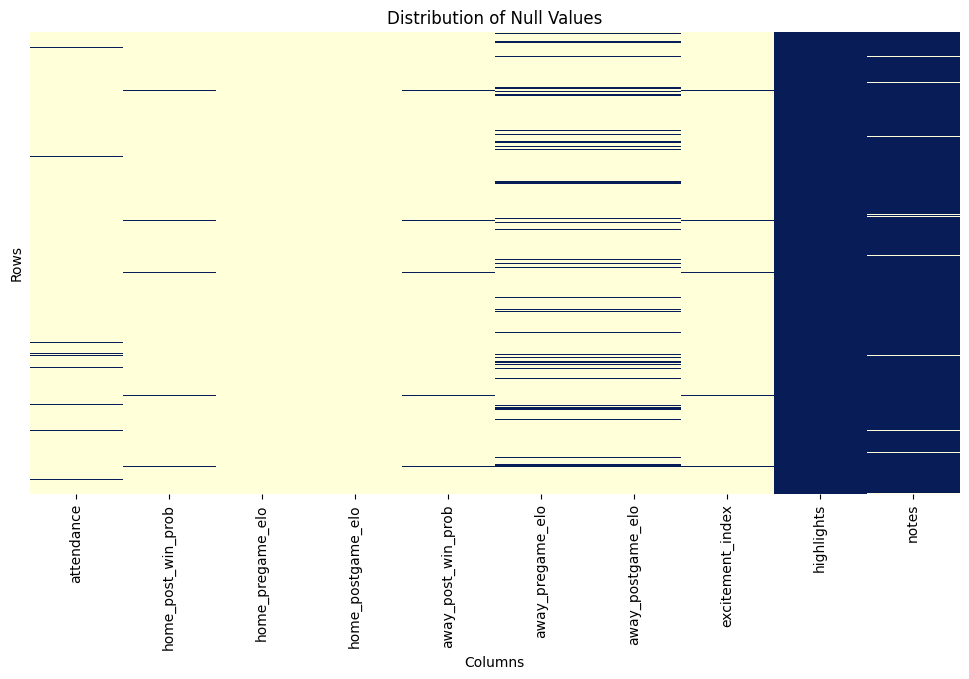

In [16]:
# Check for columns with null values
null_columns = games_df.columns[games_df.isnull().any()].tolist()

print("Columns with null values:")
for col in null_columns:
    null_count = games_df[col].isnull().sum()
    null_percentage = (null_count / len(games_df)) * 100
    print(f"{col}: {null_count} null values ({null_percentage:.2f}%)")

# Visualize the distribution of null values
plt.figure(figsize=(12, 6))
sns.heatmap(games_df[null_columns].isnull(), cbar=False, yticklabels=False, cmap='YlGnBu')
plt.title('Distribution of Null Values')
plt.xlabel('Columns')
plt.ylabel('Rows')
plt.show()

## Notes

-   We have a few columns where the vast majority of the values are null.
    -   attendance, home_post_win_prob, home_pregame_elo, home_postgame_elo, away_post_win_prob, away_pregame_elo, away_postgame_elo, excitement_index, highlights, notes
    -   highlights (100%): remove
    -   notes (98%): remove, mostly some minor notes like change of date or what championship game it is. Strange since our initial data pull is supposed to be regular season only.
    -   

In [7]:
# Display a random sample of non-null notes
non_null_notes = games_df[games_df['notes'].notnull()]
if not non_null_notes.empty:
    sample_size = min(5, len(non_null_notes))
    print(f"Random sample of {sample_size} non-null notes:")
    print(non_null_notes[['season', 'week', 'home_team', 'away_team', 'notes']].sample(sample_size))
else:
    print("No non-null notes found in the dataset.")


Random sample of 5 non-null notes:
      season  week       home_team          away_team  \
1563    2022     6             UCF                SMU   
3623    2022    14             TCU       Kansas State   
3441    2022    12  St. Johns (MN)  Northwestern (MN)   
3580    2022    13   New Hampshire            Fordham   
7248    2023    14           Texas     Oklahoma State   

                                        notes  
1563                         Moved from Oct 1  
3623            Dr Pepper Big 12 Championship  
3441  Division III Championship - First Round  
3580           FCS Championship - First Round  
7248            Dr Pepper Big 12 Championship  


Top 10 Games by Home Conference:
home_conference
SEC                            204
Big Ten                        197
ACC                            188
Pennsylvania State Athletic    177
Sun Belt                       171
Big 12                         161
Pac-12                         161
American Athletic              160
Northern Sun                   155
Mountain West                  152
Name: count, dtype: int64

Top 10 Games by Away Conference:
away_conference
Pennsylvania State Athletic    182
CAA                            169
Sun Belt                       167
Northern Sun                   158
Mid-American                   155
ACC                            149
American Athletic              144
Big Ten                        143
Big Sky                        142
Mountain West                  141
Name: count, dtype: int64

Top 10 Games by Home Division:
home_division
iii    2383
ii     1757
fbs    1722
fcs    1363
Name: count, dtype: int64

Top 10 Games by Away Divisio

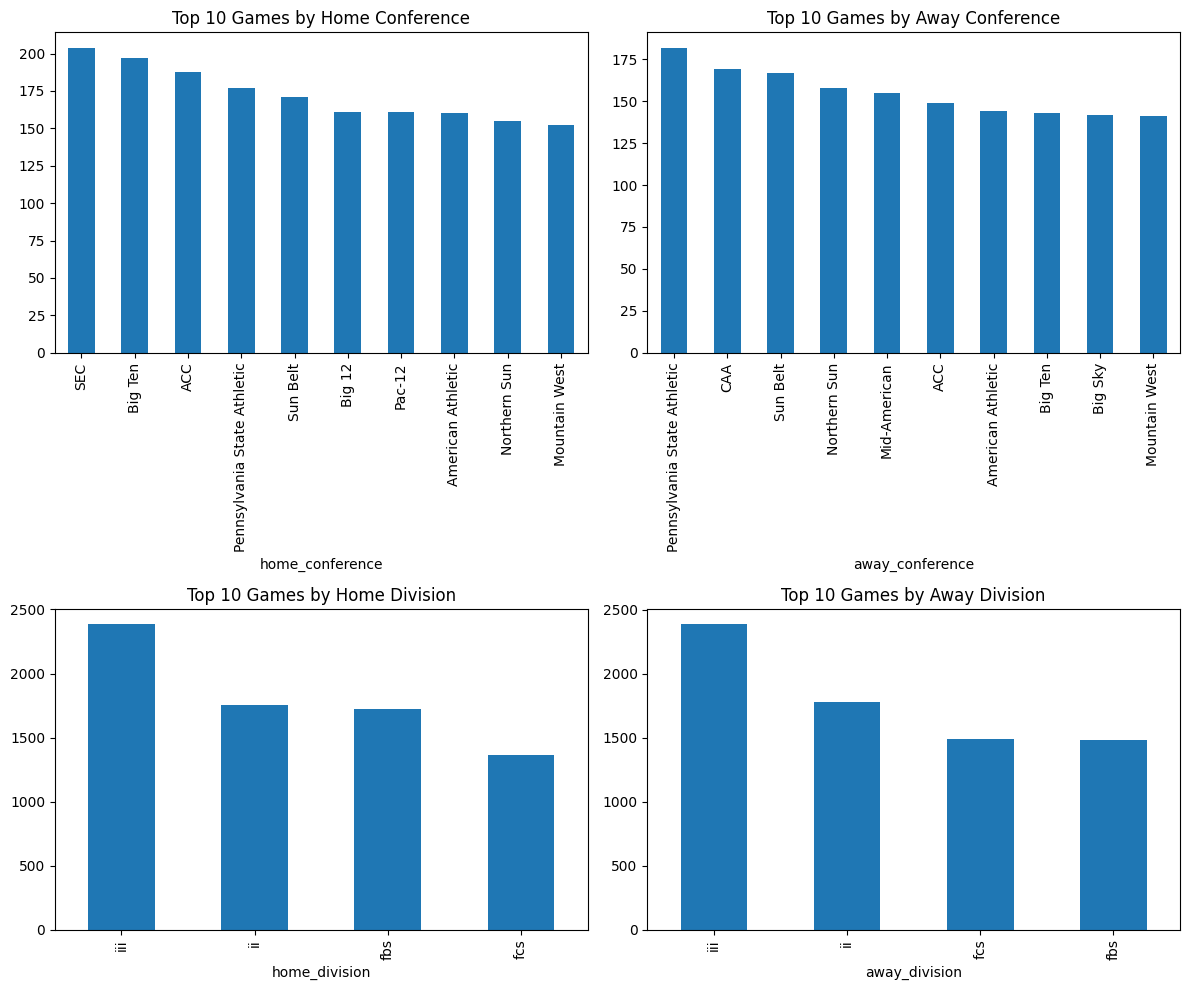

In [14]:
# Count games by conference and division
conference_counts = {
    'home': games_df['home_conference'].value_counts().nlargest(10),
    'away': games_df['away_conference'].value_counts().nlargest(10)
}

division_counts = {
    'home': games_df['home_division'].value_counts().nlargest(10),
    'away': games_df['away_division'].value_counts().nlargest(10)
}

# Display results
print("Top 10 Games by Home Conference:")
print(conference_counts['home'])
print("\nTop 10 Games by Away Conference:")
print(conference_counts['away'])
print("\nTop 10 Games by Home Division:")
print(division_counts['home'])
print("\nTop 10 Games by Away Division:")
print(division_counts['away'])

# Visualize the distribution
plt.figure(figsize=(12, 10))

plt.subplot(2, 2, 1)
conference_counts['home'].plot(kind='bar')
plt.title('Top 10 Games by Home Conference')
plt.xticks(rotation=90)

plt.subplot(2, 2, 2)
conference_counts['away'].plot(kind='bar')
plt.title('Top 10 Games by Away Conference')
plt.xticks(rotation=90)

plt.subplot(2, 2, 3)
division_counts['home'].plot(kind='bar')
plt.title('Top 10 Games by Home Division')
plt.xticks(rotation=90)

plt.subplot(2, 2, 4)
division_counts['away'].plot(kind='bar')
plt.title('Top 10 Games by Away Division')
plt.xticks(rotation=90)

plt.tight_layout()
plt.show()
